# Comparaison des modèles SARIMA, KNN et RF

## Basé avec les instants t précédents de la consommation.

Une problématique classique dans les séries temporelles consiste à prédire la série en se basant sur ses instants passés.

Ainsi si l'on utilise les n instants précédents pour prédire l'instant t; on peut voir le problème comme de l'apprentissage supervisé. La donnée (X) correspond aux instants t-n à t-1. Et la cible correspond à l'instant t. On a ainsi un problème de régression à n variables qui sont les n instants précédents.

**Nous pouvons donc comparer la performance des algorithmes classiques : KNN, RF avec le modèle SARIMA.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
import utils

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

from sklearn import preprocessing

In [2]:
#FILEPATH = 'clean_data//ener_conso_full.csv'
df = pd.read_csv('clean_data\ener_conso_full.csv', parse_dates=[0], index_col=0, squeeze=True)

In [3]:
df.head()

date_heure
2012-12-31 23:30:00+00:00    59662.0
2013-01-01 00:00:00+00:00    57866.0
2013-01-01 00:30:00+00:00    57747.0
2013-01-01 01:00:00+00:00    57234.0
2013-01-01 01:30:00+00:00    56649.0
Name: consommation_mw, dtype: float64

### Création des 3 granularités

In [4]:
df_mois= df.resample('M').sum()
df_jours = df.resample('D').sum()
df_3h = df.resample('3h').sum()

# Etude par mois

In [5]:
df_train, df_test = train_test_split(df_mois,test_size = 0.2, shuffle = False )

In [6]:
X_train, y_train = utils.create_array(df_train, 5)
X_test, y_test = utils.create_array(df_test, 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(62, 5)
(62,)
(11, 5)
(11,)


#### Instanciation des modèles et des params à tester

In [7]:
pls = PLSRegression ()
rf = RandomForestRegressor ()
knn = KNeighborsRegressor()

param_grid_pls = {'n_components': range(1,10), 'scale': [False, True]}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                        'min_samples_leaf': [1, 3, 5],
                        'max_features': ['auto', 'sqrt', 'log2']}]

param_knn = {"n_neighbors":list(range(1,41)),
             "weights": ["uniform", "distance"],
             "metric" :['manhattan', 'chebyshev','minkowski']}

gridcvs = {}

for pgrid, clf, name in zip((param_grid_pls, param_grid_rf, param_knn),
                            (pls, rf, knn),
                            ('PLSRegression', 'RF', 'KNN')):
    gcv = GridSearchCV(clf, pgrid, cv=KFold(2), refit=True)
    gridcvs[name] = gcv

### Boucle de testing

In [8]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)

outer_scores = {}

print('Calcul en cours...')
for keys, value in gridcvs.items():
    score = cross_val_score(value, X_train, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}:  R² = {100*score.mean():.2f} +/- {100*score.std():.2f}') 

Calcul en cours...
PLSRegression:  R² = 65.38 +/- 10.96
RF:  R² = 81.48 +/- 3.85
KNN:  R² = 81.35 +/- 9.06


### Entrainement:

In [9]:
rf = gridcvs['RF'].fit(X_train, y_train)
knn = gridcvs['KNN'].fit(X_train, y_train)

### SARIMA

*NB : La saisonnalité (période 12) a été déterminé via des graphs de différenciation dans les notebooks précédents.*

In [10]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
params_results = {}
print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_mois,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}12'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")

Calcul en cours...
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 AIC : 2520.0
Calcul terminé.


In [11]:
model=sm.tsa.SARIMAX(df_mois, order=(0,1,0) ,seasonal_order = (0, 1, 1, 12))
sarima=model.fit()

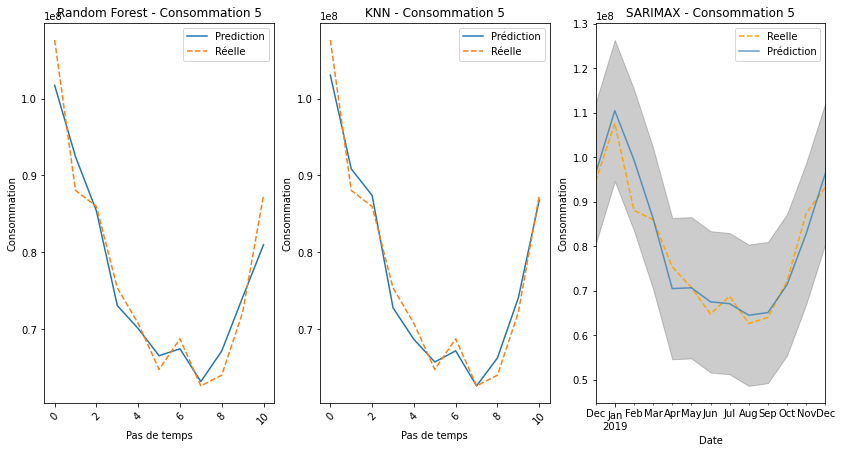

In [12]:
pred_sarima = sarima.get_prediction(start=pd.to_datetime('2018-12-31', utc=True), dynamic=False)
pred_ci = pred_sarima.conf_int()
y_pred_rf = rf.predict(X_test)
y_pred_knn = knn.predict(X_test)

plt.figure(figsize=(15,25))
plt.subplot(131)
plt.plot(y_pred_rf, label='Prediction')
plt.xticks(rotation=45)
plt.title('Random Forest - Consommation 5')
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.xlabel('Pas de temps')
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_pred_knn, label='Prédiction')
plt.xticks(rotation=45)
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.title('KNN - Consommation 5')
plt.xlabel('Pas de temps')
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = df_mois['2018-12-31':].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Consommation 5')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()
plt.show()

## MAPE des modèles

In [13]:
print(f'Best Parameters RF: {rf.best_params_}')
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_rf)
print('Test MAPE RF:', round(test_score*100,2), '%')


print(f'Best Parameters KNN: {knn.best_params_}')
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_knn)
print('Test MAPE KNN:', round(test_score*100,2), '%')

pred_mean = pred_sarima.predicted_mean
print('Best Parameters',best_params, 'AIC :', params_results[best_params])
train_score = mean_absolute_percentage_error(y_true=df_mois['2018-12-31':], y_pred=pred_mean)
print('MAPE SARIMA:',round(train_score*100,2), '%')

Best Parameters RF: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}
Test MAPE RF: 3.24 %
Best Parameters KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Test MAPE KNN: 2.37 %
Best Parameters ARIMA(0, 1, 0)x(0, 1, 1, 12)12 AIC : 2520.0
MAPE SARIMA: 3.49 %


En utilisant les 5 pas de temps précédents pour prédire le futur les modèles KNN et RF arrivent à prédire de façon précise l'instant suivant.

Cependant en étudiant uniquement seulement 5 pas de temps nos modèles ne peuvent pas repérer des dépendances temporelles à plus long terme dans le jeu de données.

Ainsi nous allons utiliser la prédiction à l'instant t pour prédire l'instant t+1, puis cette même prédiction pour prédire l'instant t+2. 

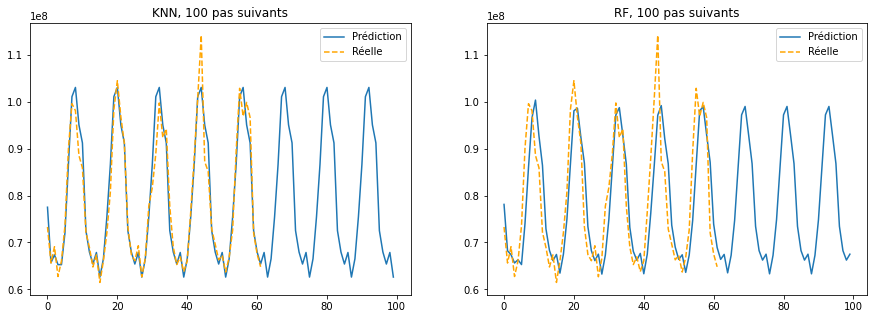

In [14]:

plt.figure(figsize=(15,5))
plt.subplot(121)
sample = np.reshape(X_train[0], (1,5))
pred = []
for i in range(100):
    next_step = knn.predict(sample)
    sample = np.concatenate([sample[:,1:], np.reshape(next_step, (1,1))], axis = 1)
    pred.append(next_step[0])
    
plt.plot(pred, label='Prédiction')
plt.plot(y_train[:100], label='Réelle', linestyle='dashed', color = 'orange')
plt.title("KNN, 100 pas suivants")
plt.legend()

plt.subplot(122)
sample = np.reshape(X_train[0], (1,5))
pred = []
for i in range(100):
    next_step = rf.predict(sample)
    sample = np.concatenate([sample[:,1:], np.reshape(next_step, (1,1))], axis = 1)
    pred.append(next_step[0])
    
plt.plot(pred, label='Prédiction')
plt.plot(y_train[:100], label='Réelle', linestyle='dashed', color = 'orange')
plt.title("RF, 100 pas suivants")
plt.legend()

**Par mois, cela semble fonctionner avec KNN, par contre la RF se retrouve vite à prédire toujours la même valeur.

# Etude par jours

**Nous nous contenterons de 2018 - 2019**

In [15]:
df_train, df_test = train_test_split(df_jours['2018':],test_size = 0.2, shuffle = False)

In [16]:
X_train, y_train = utils.create_array(df_train, 5)
X_test, y_test = utils.create_array(df_test, 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(578, 5)
(578,)
(140, 5)
(140,)


### Boucle pour paramètres :

*Nous utilisons le dictionnaire déjà créé ci-dessus.*

In [17]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)

outer_scores = {}

print('Calcul en cours...')
for keys, value in gridcvs.items():
    score = cross_val_score(value, X_train, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}:  R² = {100*score.mean():.2f} +/- {100*score.std():.2f}') 

Calcul en cours...
PLSRegression:  R² = 88.21 +/- 2.52
RF:  R² = 87.88 +/- 4.06
KNN:  R² = 85.53 +/- 3.63


### Entrainement

In [18]:
rf = gridcvs['RF'].fit(X_train, y_train)
knn = gridcvs['KNN'].fit(X_train, y_train)

### SARIMA

*La différenciation pour le coeff de saisonnalité s'est fait par ailleurs dans les autres notebooks, periode = 7*

In [19]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
params_results = {}
print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_jours,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}7'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")

Calcul en cours...
ARIMA(0, 1, 0)x(1, 1, 1, 7)7 AIC : 65905.0
Calcul terminé.


In [20]:
model=sm.tsa.SARIMAX(df_jours, order=(0,1,0) ,seasonal_order = (1, 1, 1, 7))
sarima=model.fit()

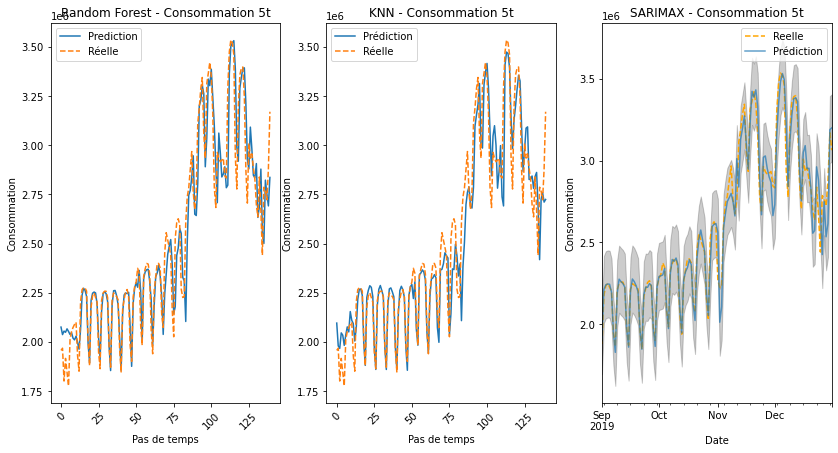

In [21]:
pred_sarima = sarima.get_prediction(start=pd.to_datetime('2019-09-01', utc=True), dynamic=False)
pred_ci = pred_sarima.conf_int()
y_pred_rf = rf.predict(X_test)
y_pred_knn = knn.predict(X_test)

plt.figure(figsize=(15,25))
plt.subplot(131)
plt.plot(y_pred_rf, label='Prediction')
plt.xticks(rotation=45)
plt.title('Random Forest - Consommation 5t')
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.xlabel('Pas de temps')
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_pred_knn, label='Prédiction')
plt.xticks(rotation=45)
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.title('KNN - Consommation 5t')
plt.xlabel('Pas de temps')
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = df_jours['2019-09-01':].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Consommation 5t')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()
plt.show()

## MAPE des modèles

In [22]:
print(f'Best Parameters RF: {rf.best_params_}')
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_rf)
print('Test MAPE RF:', round(test_score*100,2), '%')


print(f'Best Parameters KNN: {knn.best_params_}')
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_knn)
print('Test MAPE KNN:', round(test_score*100,2), '%')

pred_mean = pred_sarima.predicted_mean
print('Best Parameters',best_params, 'AIC :', params_results[best_params])
train_score = mean_absolute_percentage_error(y_true=df_jours['2019-09-01':], y_pred=pred_mean)
print('MAPE SARIMA:',round(train_score*100,2), '%')

Best Parameters RF: {'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 250}
Test MAPE RF: 3.81 %
Best Parameters KNN: {'metric': 'chebyshev', 'n_neighbors': 6, 'weights': 'distance'}
Test MAPE KNN: 3.77 %
Best Parameters ARIMA(0, 1, 0)x(1, 1, 1, 7)7 AIC : 65905.0
MAPE SARIMA: 2.23 %


RF et KNN n'ont pas à rougir face à SARIMAX lorsqu'ils prennent en compte les consommations des instants précédents pour prédire la consommation suivante. 

**Quand est-il sur le long terme ? (en prenant les prédictions des instants précédents pour prédire les pas de temps suivant ?** 

*NB :  Utiliser la prédiction à l'instant t pour prédire l'instant t+1 et ainsi de suite consiste à réaliser une prédiction autorégressive car elle se base sur sa propre prédiction pour prédire un futur plus lointain.*

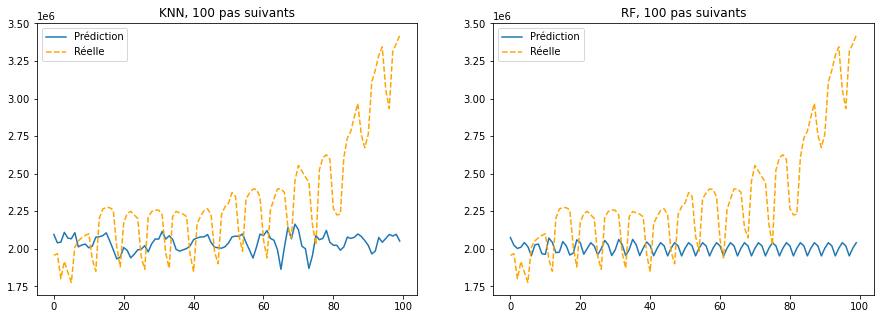

In [23]:

plt.figure(figsize=(15,5))
plt.subplot(121)
sample = np.reshape(X_test[0], (1,5))
pred = []
for i in range(100):
    next_step = knn.predict(sample)
    sample = np.concatenate([sample[:,1:], np.reshape(next_step, (1,1))], axis = 1)
    pred.append(next_step[0])
    
plt.plot(pred, label='Prédiction')
plt.plot(y_test[:100], label='Réelle', linestyle='dashed', color = 'orange')
plt.title("KNN, 100 pas suivants")
plt.legend()

plt.subplot(122)
sample = np.reshape(X_test[0], (1,5))
pred = []
for i in range(100):
    next_step = rf.predict(sample)
    sample = np.concatenate([sample[:,1:], np.reshape(next_step, (1,1))], axis = 1)
    pred.append(next_step[0])
    
plt.plot(pred, label='Prédiction')
plt.plot(y_test[:100], label='Réelle', linestyle='dashed', color = 'orange')
plt.title("RF, 100 pas suivants")
plt.legend()

KNN et RF n'arrivent plus à suivre sur le long terme. Il est certain que pour une granularité de 3 heures cela produise la même chose.

Vérifions tout de même : 

# Granularité : 3 heures

Nous nous contenterons de 2 mois de données

In [24]:
df_train, df_test = train_test_split(df_3h['2019-12-01':],test_size = 0.2, shuffle = False )

In [25]:
X_train, y_train = utils.create_array(df_train, 5)
X_test, y_test = utils.create_array(df_test, 5)
print(X_train.shape)
print(y_train.shape)

(192, 5)
(192,)


### Boucle pour paramètres :
*Nous utilisons le dictionnaire déjà créé ci-dessus.*

In [26]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)

outer_scores = {}

print('Calcul en cours...')
for keys, value in gridcvs.items():
    score = cross_val_score(value, X_train, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}:  R² = {100*score.mean():.2f} +/- {100*score.std():.2f}') 

Calcul en cours...
PLSRegression:  R² = 30.27 +/- 3.44
RF:  R² = -31.05 +/- 19.21
KNN:  R² = -9.10 +/- 24.56


### Entrainement

In [27]:
rf = gridcvs['RF'].fit(X_train, y_train)
knn = gridcvs['KNN'].fit(X_train, y_train)

### SARIMAX
*periode : 8 - notebook précédent*

In [28]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]
params_results = {}
print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_3h,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}8'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")

Calcul en cours...
ARIMA(1, 0, 0)x(1, 0, 0, 8)8 AIC : 6.0
Calcul terminé.


In [29]:
model=sm.tsa.SARIMAX(df_3h, order=(1,1,0) ,seasonal_order = (1, 0, 1, 8))
sarima=model.fit()

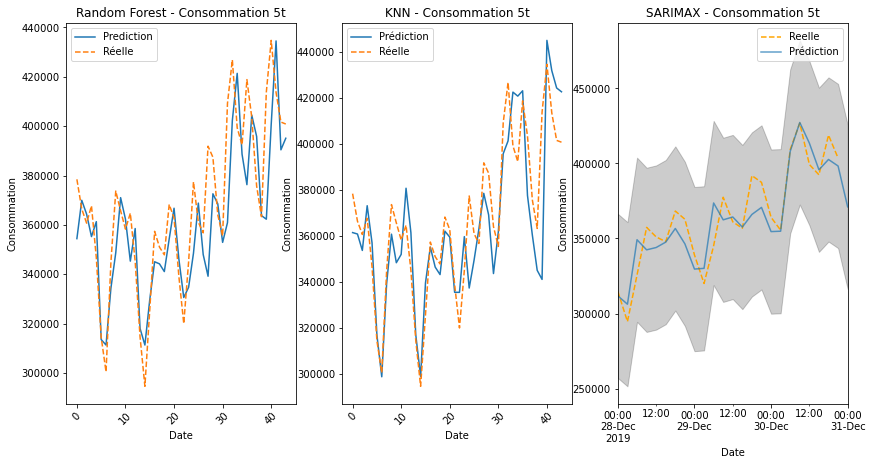

In [31]:
pred_sarima = sarima.get_prediction(start=pd.to_datetime('2019-12-28', utc= True),end=pd.to_datetime('2019-12-31', utc= True), dynamic=False)
pred_ci = pred_sarima.conf_int()
y_pred_rf = rf.predict(X_test)
y_pred_knn = knn.predict(X_test)

plt.figure(figsize=(15,25))
plt.subplot(131)
plt.plot(y_pred_rf, label='Prediction')
plt.title('Random Forest - Consommation 5t')
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_pred_knn, label='Prédiction')
plt.plot(y_test, label='Réelle', linestyle='dashed')
plt.title('KNN - Consommation 5t')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = df_3h['2019-12-28':'2019-12-30'].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Consommation 5t')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()
plt.show()


## MAPE des modèles

In [36]:
print(f'Best Parameters RF: {rf.best_params_}')
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_rf)
print('Test MAPE RF:', round(test_score*100,2), '%')


print(f'Best Parameters KNN: {knn.best_params_}')
test_score = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_knn)
print('Test MAPE KNN:', round(test_score*100,2), '%')

pred_mean = pred_sarima.predicted_mean
print('Best Parameters',best_params, 'AIC :', params_results[best_params])
train_score = mean_absolute_percentage_error(y_true=df_3h['2019-12-28':'2019-12-30'], y_pred=pred_mean['2019-12-28':'2019-12-30'])
print('MAPE SARIMA:',round(train_score*100,2), '%')

Best Parameters RF: {'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 10}
Test MAPE RF: 3.88 %
Best Parameters KNN: {'metric': 'chebyshev', 'n_neighbors': 2, 'weights': 'distance'}
Test MAPE KNN: 3.69 %
Best Parameters ARIMA(1, 0, 0)x(1, 0, 0, 8)8 AIC : 6.0
MAPE SARIMA: 2.88 %


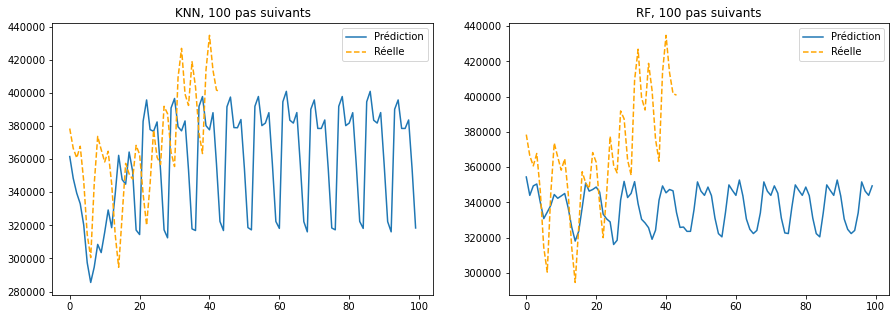

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sample = np.reshape(X_test[0], (1,5))
pred = []
for i in range(100):
    next_step = knn.predict(sample)
    sample = np.concatenate([sample[:,1:], np.reshape(next_step, (1,1))], axis = 1)
    pred.append(next_step[0])
    
plt.plot(pred, label='Prédiction')
plt.plot(y_test[:100], label='Réelle', linestyle='dashed', color = 'orange')
plt.title("KNN, 100 pas suivants")
plt.legend()

plt.subplot(122)
sample = np.reshape(X_test[0], (1,5))
pred = []
for i in range(100):
    next_step = rf.predict(sample)
    sample = np.concatenate([sample[:,1:], np.reshape(next_step, (1,1))], axis = 1)
    pred.append(next_step[0])
    
plt.plot(pred, label='Prédiction')
plt.plot(y_test[:100], label='Réelle', linestyle='dashed', color = 'orange')
plt.title("RF, 100 pas suivants")
plt.legend()


même conclusion, les modèles RF et KNN s'epuisent sur le long terme.